In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric_temporal.nn.recurrent import A3TGCN2

from torch_geometric_temporal.signal import temporal_signal_split
from torch_geometric.datasets import Planetoid
from torch_geometric_temporal.dataset import METRLADatasetLoader
import pandas as pd
from torch_scatter import gather_csr, scatter, segment_csr


import sys
from utils_analysis import *

# auto refresh
%load_ext autoreload
%autoreload 2
# GPU support
DEVICE = torch.device('cuda:0') # cuda
shuffle=True
batch_size = 32

device = torch.device(
    "cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [6]:
import os.path as osp
path = osp.join(osp.dirname('/mnt/d1/siji/projects/timeseries/'),
                    '..', 'data', 'Planetoid')
DATA_SET='Cora'
# DATA_SET='PubMed'
# DATA_SET='CiteSeer'
SPLIT='public'
dataset = Planetoid(path, name=DATA_SET, split=SPLIT)
# dataset = Planetoid(path, name='Cora', split=SPLIT)
data = dataset[0]

In [7]:
# number edges 
edges = data.edge_index.t().tolist()
print('edges', len(edges))
# print node
print('nodes', len(data.x))
# features per node
print('features per node', len(data.x[0]))
# how many train nodes?
print('train nodes', sum(data.train_mask))
# how many labels?
print('labels', len(data.y.unique()))


edges 10556
nodes 2708
features per node 1433
train nodes tensor(140)
labels 7


Text(0.5, 1.0, 'sigmoid(X@X.T) histogram')

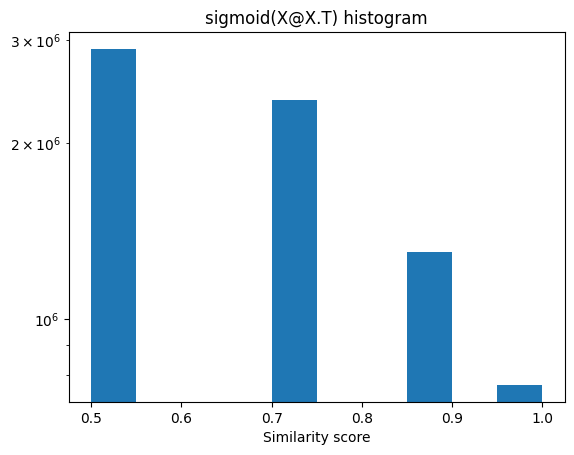

In [8]:
decode = data.x.to(device)
# random mask 20% of the nodes
mask = torch.rand(decode.size(0)) < 1

decode = decode[mask]
decode = (decode@decode.T)
adj = torch.sigmoid(decode)
# adj=decode
plt.hist(adj.flatten().detach().cpu().numpy(), bins=10)
#     # use log on y axis
plt.yscale('log')
plt.xlabel('Similarity score')
plt.title('sigmoid(X@X.T) histogram')

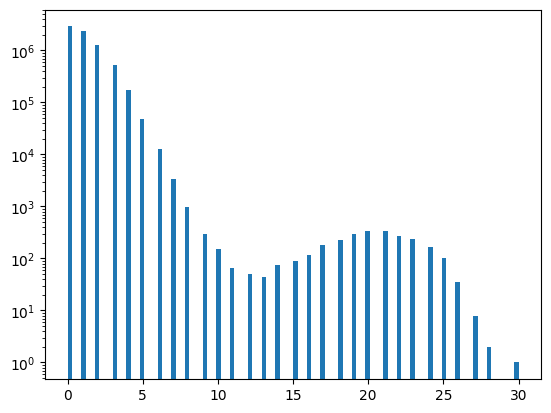

In [9]:

plt.hist(decode.flatten().detach().cpu().numpy(), bins=100)
#     # use log on y axis
plt.yscale('log')

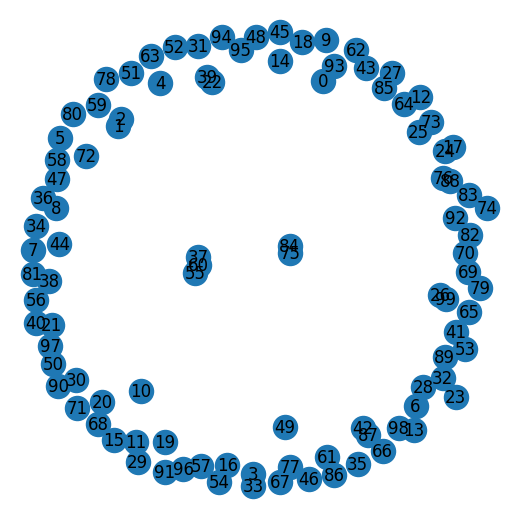

In [14]:
vis_N_nodes(100, data.x, data.edge_index.t().tolist())

In [15]:
# find the nodes which is class 0
data_c0=data.x[data.y==0].cpu().detach().numpy()
# find the nodes which is class 1
data_c1=data.x[data.y==1].cpu().detach().numpy()
data_c2=data.x[data.y==2].cpu().detach().numpy()
data_c3=data.x[data.y==3].cpu().detach().numpy()
data_c4=data.x[data.y==4].cpu().detach().numpy()
data_c5=data.x[data.y==5].cpu().detach().numpy()
data_c6=data.x[data.y==6].cpu().detach().numpy()

In [19]:
data_overview=pd.DataFrame({
    'class 0':data_c0.mean(axis=0),
    'class 1':data_c1.mean(axis=0),
    'class 2':data_c2.mean(axis=0),
    'class 3':data_c3.mean(axis=0),
    'class 4':data_c4.mean(axis=0),
    'class 5':data_c5.mean(axis=0),
    'class 6':data_c6.mean(axis=0),
})

In [22]:
data_overview

,class 0,class 1,class 2,class 3,class 4,class 5,class 6
0,0.000000,0.004608,0.007177,0.003667,0.009390,0.013423,0.005556
1,0.000000,0.027650,0.011962,0.013447,0.002347,0.023490,0.016667
2,0.028490,0.046083,0.014354,0.023227,0.028169,0.033557,0.016667
3,0.042735,0.036866,0.016746,0.025672,0.028169,0.010067,0.033333
4,0.019943,0.009217,0.004785,0.008557,0.084507,0.359060,0.022222
...,...,...,...,...,...,...,...
1428,0.000000,0.004608,0.000000,0.000000,0.004695,0.000000,0.000000
1429,0.002849,0.009217,0.016746,0.012225,0.016432,0.016779,0.011111
1430,0.011396,0.000000,0.000000,0.001222,0.000000,0.003356,0.000000
1431,0.019943,0.027650,0.009569,0.018337,0.025822,0.036913,0.061111


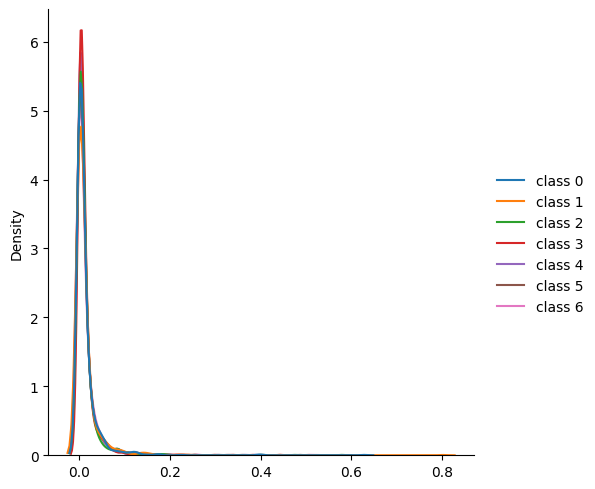

In [26]:
sns.displot(data_overview, kind='kde')

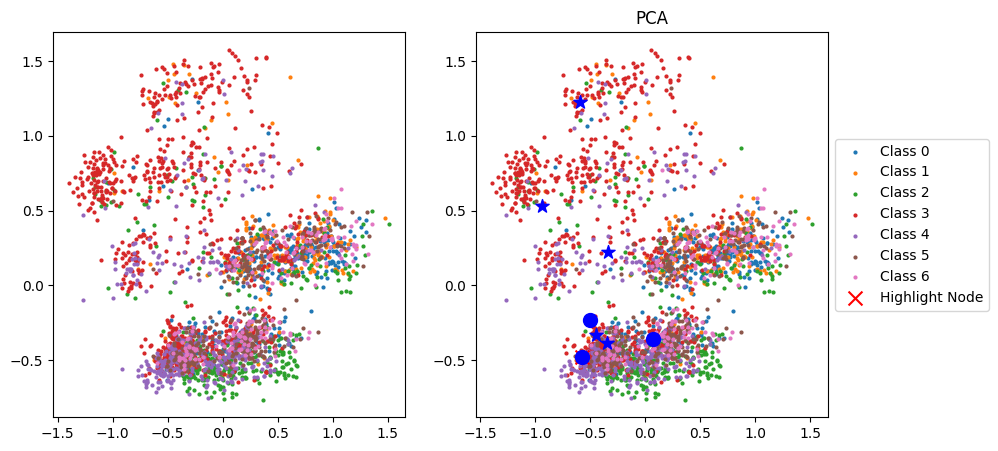

In [105]:
pca_analysis(data.x, data.y,7)
# also plot node 1728, neighbor nodes of 1728 as starts; neighbor nodes of 1728 based on similarity as dots

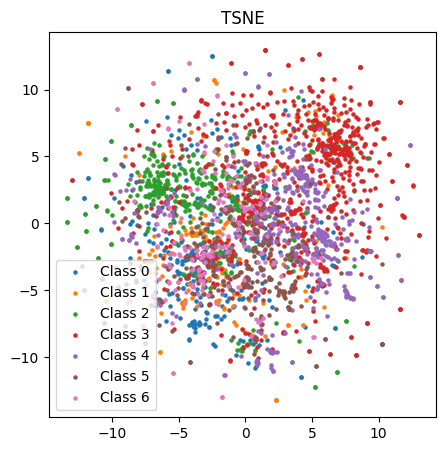

In [35]:
tsne_analysis(data.x, data.y,7) # takes a while

In [37]:
# loop through edge index, find the edge is intra-class or inter-class
# 2-d map, 7 BY 7
results=np.zeros((7,7))
for edge in data.edge_index.t().tolist():
    start_node, end_node = edge
    start_class = data.y[start_node]
    end_class = data.y[end_node]
    
    results[start_class][end_class] += 1
    

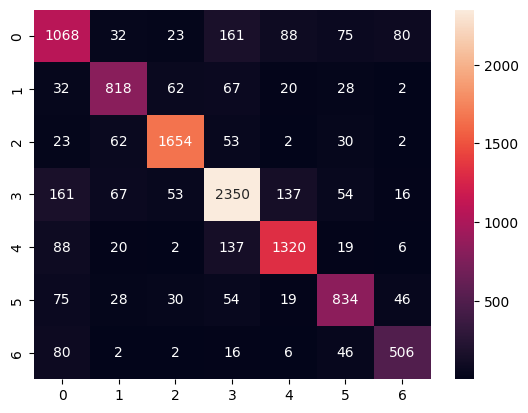

In [43]:
start_end_cluster_distribution(data.edge_index.t().tolist(), data.y,7)

In [87]:
# get pred result
# load tensor from fn.pt file
pred_gcn=torch.load(f'./results/{DATA_SET}_pred_GCN.pt')
pred_mlp=torch.load(f'./results/{DATA_SET}_pred_MLP.pt')
pred_infer=torch.load(f'./results/{DATA_SET}_pred_Infer.pt')

# print the true label and pred label
start_at=20
CHECH_NUM=30
gt_y=data.y[data.test_mask][start_at:CHECH_NUM]

pred_gcn=pred_gcn[data.test_mask].argmax(dim=-1)[start_at:CHECH_NUM]
pred_mlp=pred_mlp[data.test_mask].argmax(dim=-1)[start_at:CHECH_NUM]
pred_infer=pred_infer[data.test_mask].argmax(dim=-1)[start_at:CHECH_NUM]

In [88]:
print('GT:\t',gt_y)
print('GCN:\t',pred_gcn)
print('Infer:\t',pred_infer)
print('MLP:\t',pred_mlp)

# test set start at index 1708

GT:	 tensor([3, 2, 2, 2, 2, 2, 2, 1, 2, 2])
GCN:	 tensor([2, 2, 2, 2, 2, 1, 2, 1, 2, 2])
Infer:	 tensor([3, 0, 2, 2, 6, 0, 2, 5, 2, 2])
MLP:	 tensor([0, 5, 2, 0, 1, 1, 2, 5, 2, 2])


In [74]:
# find the 2nd node, GCN is correct, both MLP/Infer is wrong
data.y[1709]

tensor(3)

In [101]:
# pick a node, see the original edgelist vs inferred edgelist
node_idx=1728
# original edge list
original_edges_set = []
edges = data.edge_index.t().tolist()
for start_nodes in (edges):
    if start_nodes[0] ==node_idx and start_nodes[1] !=node_idx:
        original_edges_set.append(start_nodes[1])
     
# inferred edge list
inferred_edges_set = []
decode = data.x.to(device)
decode = (decode@decode.T)
adj = torch.sigmoid(decode)
neighbors = adj[node_idx]
for i, neighbor in enumerate(neighbors):
    if neighbor>0.98:
        inferred_edges_set.append(( i))
        
print(original_edges_set)
print(inferred_edges_set)
# find intersection of original and inferred
intersection = set(original_edges_set).intersection(set(inferred_edges_set))
print('intersetion', intersection)


[961, 1358, 2257, 2555, 2599]
[1299, 1728, 2577]
intersetion set()


In [168]:
# we want to see filter out the edge list based on cluster
# find the nodes which is class 0
keep_cluster=0
filtter_edges = []
for edge in data.edge_index.t().tolist():
    start_node, end_node = edge
    start_class = data.y[start_node]
    end_class = data.y[end_node]
    
    if start_class==keep_cluster or end_class==keep_cluster:
        filtter_edges.append(edge)
# reduce data.x based on filtered_edges
filtter_edges=torch.tensor(filtter_edges).t()
desc=scatter(data.x[filtter_edges[0]], filtter_edges[1], dim=0,  reduce='add')

In [169]:
desc.shape

torch.Size([2703, 1433])

In [177]:
a=torch.ones((3,3))
src=torch.ones((3,3))
index = torch.tensor([[0,0,1,1,2], [0,1,1,0,2]])

print(index[0].shape)
# dest.scatter_add_(1, index, src)    
desc=scatter(src[index[0]], index[1], dim=0,  reduce='add')
#  scatter(inputs, index, dim=self.node_dim, dim_size=dim_size,
                        #    reduce=self.aggr)
print(desc.shape)
print(desc)

torch.Size([5])
torch.Size([3, 3])
tensor([[2., 2., 2.],
        [2., 2., 2.],
        [1., 1., 1.]])


In [299]:
a=torch.tensor([[1],[2.],[3]]) 

b=torch.clone(a)
# a=a.unsqueeze(1) # add dim in the middle
# b=b.unsqueeze(0) # add dim in the front

# src=a-b
# src=src.squeeze()
print('distance matrix ',src.shape)
l=torch.tensor([[1.,0,0],[0,1,0],[0,0,1]])
l_list=torch.tensor([[0,1,2],[0,1,2]])
scatter(a[l_list[0]], l_list[1], dim=0,  reduce='minus')

distance matrix  torch.Size([3])


ValueError: 

## Calcualte P_direchlet

In [377]:
# adj=torch.tensor([[1.,0,0],[0,1,0],[0,0,1]])
adj=torch.zeros((3,3))
adj[0][1]=1
adj[1][0]=1
adj[0][2]=1
adj[2][0]=1
# adj[1][2]=1
# adj[2][1]=1 
# adj[0][2]=1
# adj[2][0]=1
x=torch.tensor([[4,4],[2.,2],[2,2]]) # 3x1



# normalize adj
D = torch.diag_embed(torch.sum(adj, dim=1))
L = D - adj
deg_inv_sqrt = torch.pow(D.diag(), -0.5)
deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
deg_inv_sqrt = torch.diag_embed(deg_inv_sqrt)
L_sys = deg_inv_sqrt@L@deg_inv_sqrt

print(torch.sqrt(torch.sum(torch.diag(x.T@L_sys@x))) ) # should only use diagonal sum
print(x.T@L_sys@x)
print(x.T@L@x)

tensor(1.6569)
tensor([[1.3726, 1.3726],
        [1.3726, 1.3726]])
tensor([[8., 8.],
        [8., 8.]])


In [390]:
# adj=torch.tensor([[1.,0,0],[0,1,0],[0,0,1]])
adj=torch.zeros((3,3))
adj[0][1]=1
adj[1][0]=1
# adj[0][0]=1

x=torch.tensor([[4,4],[2.,2],[2,2]]) # 3x1



# normalize adj
D = torch.diag_embed(torch.sum(adj, dim=1))
L = D - adj
deg_inv_sqrt = torch.pow(D.diag(), -0.5)
deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
deg_inv_sqrt = torch.diag_embed(deg_inv_sqrt)
L_sys = deg_inv_sqrt@L@deg_inv_sqrt
A_sys = deg_inv_sqrt@adj@deg_inv_sqrt
print(torch.sqrt(torch.sum(torch.diag(x.T@L_sys@x))) ) 
print(torch.sqrt(torch.sum(torch.diag(x.T@A_sys@x))) ) 
print(x.T@L_sys@x)
print(x.T@L@x)

tensor(2.8284)
tensor(5.6569)
tensor([[4., 4.],
        [4., 4.]])
tensor([[4., 4.],
        [4., 4.]])


: 

In [379]:
Adj=torch.tensor([[0.,1,0],[1,0,1],[0,1,0]])
D=torch.diag_embed(torch.sum(Adj, dim=1))
L=D-Adj

print(Adj)
print(D)
print(L)

tensor([[0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.]])
tensor([[1., 0., 0.],
        [0., 2., 0.],
        [0., 0., 1.]])
tensor([[ 1., -1.,  0.],
        [-1.,  2., -1.],
        [ 0., -1.,  1.]])


In [381]:
deg_inv_sqrt = torch.pow(D.diag(), -0.5)
deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
deg_inv_sqrt = torch.diag_embed(deg_inv_sqrt)
# L_sys = deg_inv_sqrt@adj_sim@deg_inv_sqrt # CHECK !!!! 072624
L_sys = deg_inv_sqrt@(L)@deg_inv_sqrt # this is the correct way of normalize L
print(L_sys)

tensor([[ 1.0000, -0.7071,  0.0000],
        [-0.7071,  1.0000, -0.7071],
        [ 0.0000, -0.7071,  1.0000]])


In [16]:
# random
a=torch.randn(2,3)
centers=torch.randn(4,3) # have 4 centers, each center has 3 features
# find the nearest center
# distances = torch.cdist(a, centers)
# print(distances)
inner_product=torch.inner(a, centers)
print(inner_product)
# softmax
inner_product=F.softmax(inner_product, dim=1)
print(inner_product)
print(inner_product.shape)





tensor([[ 0.1832, -1.1545, -2.1010, -0.0134],
        [ 1.0045,  1.9288,  4.3862, -0.6861]])
tensor([[0.4575, 0.1201, 0.0466, 0.3758],
        [0.0302, 0.0761, 0.8882, 0.0056]])
torch.Size([2, 4])


In [42]:
centers=torch.randn(2,3) #centers
a=torch.randn(5,3) # a is a random point
# find the distance between a and centers
distances = torch.cdist(a, centers)
print(distances)
print(distances.shape)
# find the nearest center index
_, idx = distances.min(dim=1)
print(idx)

# return chosen centers
chosen_centers = centers[idx]
print(chosen_centers)

tensor([[1.5030, 2.8056],
        [1.1168, 2.5577],
        [2.8998, 1.5187],
        [2.3643, 2.6876],
        [2.1907, 0.6966]])
torch.Size([5, 2])
tensor([0, 0, 1, 0, 1])
tensor([[-1.3190,  0.0259, -0.8595],
        [-1.3190,  0.0259, -0.8595],
        [ 0.8586,  0.9361, -0.1148],
        [-1.3190,  0.0259, -0.8595],
        [ 0.8586,  0.9361, -0.1148]])


In [47]:
centers=torch.tensor([[0.,0,0],[1,1,1]]) #2,3
a=torch.tensor([[0.5,0.0,0]])
torch.cdist(a, centers, p=2)

tensor([[0.5000, 1.5000]])

In [48]:
# get iris dataset
from sklearn import datasets
iris = datasets.load_iris()
iris_data = iris.data

In [51]:
iris.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])